In [49]:
!nvidia-smi

Thu Feb  5 15:35:14 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   75C    P0             33W /   70W |     372MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [102]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cmap
import seaborn as sns

from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.applications import EfficientNetB0, MobileNetV2
from keras.callbacks import EarlyStopping
from keras.utils import plot_model

import warnings
warnings.filterwarnings('ignore')

## **Импорт обучающего набора**

In [87]:
DATASET_DIR = '/content/drive/MyDrive/Dataset'
IMG_SIZE = 128
BATCH_SIZE = 16
NUM_CLASSES = 2
EPOCHS = 50


train_ds = keras.utils.image_dataset_from_directory(
    os.path.join(DATASET_DIR, '01_Train'),
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    shuffle=True
)

val_ds = keras.utils.image_dataset_from_directory(
    os.path.join(DATASET_DIR, '02_Val'),
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    shuffle=True
)

test_ds = keras.utils.image_dataset_from_directory(
    os.path.join(DATASET_DIR, '03_Test'),
    image_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    label_mode='categorical',
    shuffle=True
)

class_names = train_ds.class_names
print('Классы:', class_names)

Found 310 files belonging to 2 classes.
Found 64 files belonging to 2 classes.
Found 64 files belonging to 2 classes.
Классы: ['ImpactStrctures', 'VolcanoStructures']


# **Модель на основе EfficientNetB0 (базовая)**

## **Разработка архитектуры**

In [95]:
# Загрузка базовой модели
EfficientNetB0_backbone = EfficientNetB0(
    include_top=False,
    weights='imagenet',
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

# Заморозка весов
EfficientNetB0_backbone.trainable = False

# Входной слой
inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3), name='input_layer')

# Аугментация
x = layers.RandomFlip('horizontal', name='augmentation_flip')(inputs)
x = layers.RandomRotation(0.15, name='augmentation_rotation')(x)
x = layers.RandomZoom(0.15, name='augmentation_zoom')(x)
x = layers.RandomContrast(0.2, name='augmentation_contrast')(x)

# Препроцессинг
x = keras.applications.efficientnet.preprocess_input(x)
x = EfficientNetB0_backbone(x)

# Новый классификатор
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.4)(x)

# Выходной слой
outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)

# Сборка модели
base_model = keras.Model(inputs, outputs, name='EfficientNetB0_base_model')

# Компиляция модели
base_model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

base_model.summary()

Model: "EfficientNetB0_base_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ augmentation_flip (RandomFlip)  │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ augmentation_rotation           │ (None, 128, 128, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ augmentation_zoom (RandomZoom)  │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ augmentation_contrast           │ (None, 128, 128, 3)    │             0 │
│ (RandomContrast)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 4, 4, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,383,141 (16.72 MB)

 Trainable params: 331,010 (1.26 MB)

 Non-trainable params: 4,052,131 (15.46 MB)

## **Трансферное обучение**

In [47]:
# Обратный вызов для ранней остановки обучения
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

### **Предобучение**

In [96]:
# Обучение классификатора
base_history = base_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    verbose=1
)

Epoch 1/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 20s 321ms/step - accuracy: 0.6817 - loss: 0.7455 - val_accuracy: 0.7344 - val_loss: 0.5571
Epoch 2/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 109ms/step - accuracy: 0.8703 - loss: 0.3032 - val_accuracy: 0.7656 - val_loss: 0.4617
Epoch 3/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - accuracy: 0.9130 - loss: 0.2602 - val_accuracy: 0.7031 - val_loss: 0.4883
Epoch 4/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.9291 - loss: 0.1790 - val_accuracy: 0.7812 - val_loss: 0.5422
Epoch 5/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.9210 - loss: 0.1455 - val_accuracy: 0.7500 - val_loss: 0.5272
Epoch 6/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.9406 - loss: 0.1636 - val_accuracy: 0.7812 - val_loss: 0.5281
Epoch 7/30
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.9466 - loss: 0.1713 - val_accuracy: 0.7656 - val_loss: 0.5215


##### **Оценка качества**

In [50]:
# Метрики на тесте, этап предобучения
metrics = base_model.evaluate(test_ds)
metrics

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.7083 - loss: 0.4734


[0.3925066590309143, 0.796875]

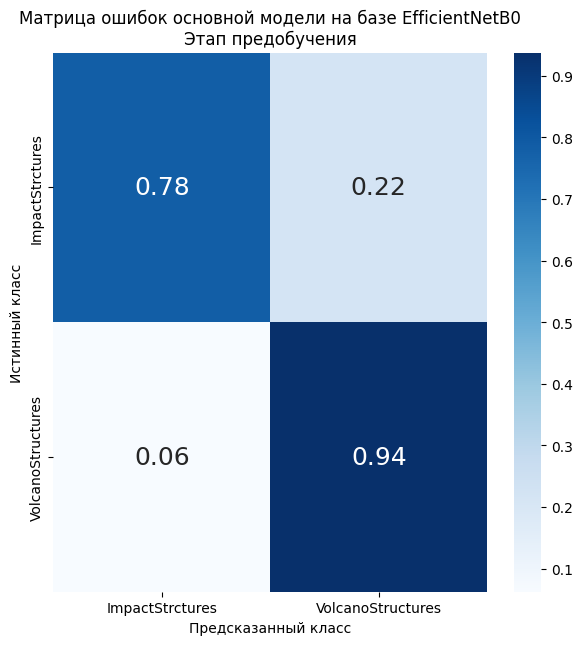

In [51]:
# Оценка качества модели, этап предобучения
y_true_list = []
y_pred_list = []

for images, labels in val_ds:
    preds = base_model.predict(images, verbose=0)

    # Обработка предсказаний
    y_pred_list.extend(np.argmax(preds, axis=1))

    # Обработка меток
    labels_np = labels.numpy()
    if len(labels_np.shape) > 1:
        y_true_list.extend(np.argmax(labels_np, axis=1))
    else:
        y_true_list.extend(labels_np)

# Матрица ошибок, этап предобучения
y_true = np.array(y_true_list)
y_pred = np.array(y_pred_list)

cm = confusion_matrix(y_true, y_pred, normalize='true')

plt.figure(figsize=(7, 7))
sns.heatmap(
    cm,
    annot=True,
    annot_kws={'size': 18},
    fmt='.2f',
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')
plt.title('Матрица ошибок основной модели на базе EfficientNetB0\nЭтап предобучения')
plt.show()

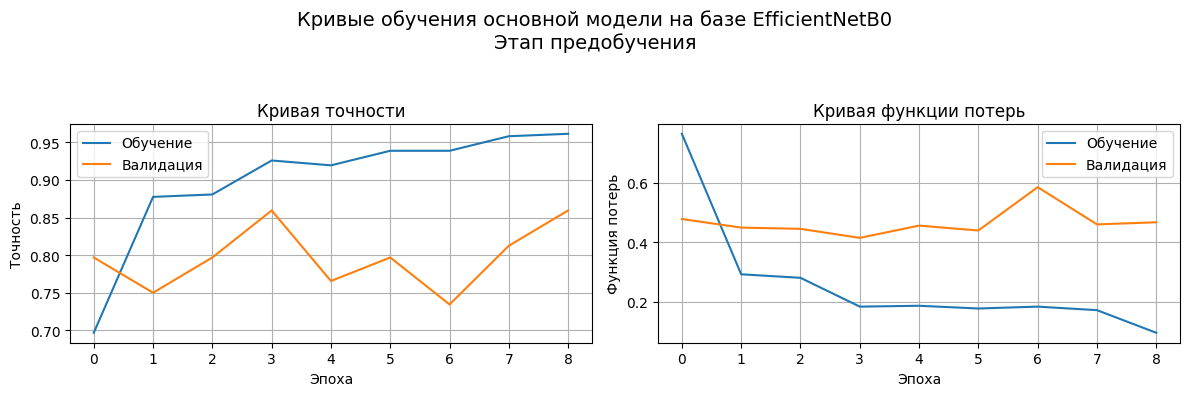

In [52]:
# Функция для визуализации кривых обучения
def plot_training_curves(history):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    axes[0].plot(history.history['accuracy'], label='Обучение')
    axes[0].plot(history.history.get('val_accuracy', []), label='Валидация')
    axes[0].set_title('Кривая точности')
    axes[0].set_xlabel('Эпоха')
    axes[0].set_ylabel('Точность')
    axes[0].legend()
    axes[0].grid(True)

    axes[1].plot(history.history['loss'], label='Обучение')
    axes[1].plot(history.history.get('val_loss', []), label='Валидация')
    axes[1].set_title('Кривая функции потерь')
    axes[1].set_xlabel('Эпоха')
    axes[1].set_ylabel('Функция потерь')
    axes[1].legend()
    axes[1].grid(True)

    fig.suptitle(
        'Кривые обучения основной модели на базе EfficientNetB0\nЭтап предобучения',
        fontsize=14
    )

    plt.tight_layout(rect=[0, 0, 1, 0.93])
    plt.show()


# Визуализация кривых обучения, этап предобучения
plot_training_curves(base_history)

#### **Интерпретация работы**

In [99]:
# Grad-CAM
def get_gradcam_heatmap(img_tensor, model, last_conv_layer_name='top_conv', pred_index=None):
    # Извлечение компонентов модели
    flip_layer = model.get_layer('augmentation_flip')
    rot_layer = model.get_layer('augmentation_rotation')
    zoom_layer = model.get_layer('augmentation_zoom')
    contrast_layer = model.get_layer('augmentation_contrast')
    backbone = model.get_layer('efficientnetb0')

    # Создание головы
    found = False
    head_layers = []
    for layer in model.layers:
        if found:
            head_layers.append(layer)
        if layer == backbone:
            found = True

    # Вычисление GradientTape
    with tf.GradientTape() as tape:
        # Проход через аугментацию
        x = flip_layer(img_tensor, training=False)
        x = rot_layer(x, training=False)

        inner_model = tf.keras.Model(
            inputs=backbone.inputs,
            outputs=[backbone.get_layer(last_conv_layer_name).output, backbone.output]
        )

        conv_outputs, backbone_features = inner_model(x, training=False)

        # Проход через финальные слои
        y = backbone_features
        for layer in head_layers:
            y = layer(y, training=False)

        predictions = y

        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    # Расчет градиентов
    grads = tape.gradient(class_channel, conv_outputs)

    # Исключение
    if grads is None:
        raise ValueError('Градиенты не найдены')

    # Сборка Heatmap
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    heatmap = conv_outputs[0] @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Активация ReLU и нормализация
    heatmap = tf.maximum(heatmap, 0) / (tf.math.reduce_max(heatmap) + 1e-10)
    return heatmap.numpy()

In [111]:
# Визуализация
def plot_gradcam_comparison(img_path, heatmap, alpha=0.6):
    # Загрузка исходного снимка
    img = tf.keras.utils.load_img(img_path, target_size=(128, 128))
    img_array = tf.keras.utils.img_to_array(img) / 255.0

    # Подготовка Heatmap
    heatmap_resized = tf.image.resize(heatmap[..., np.newaxis], (128, 128))
    heatmap_resized = tf.squeeze(heatmap_resized).numpy()

    # Создание наложенного изображения (Superimposed)
    jet = cmap.get_cmap('jet')

    jet_colors = jet(heatmap_resized)

    jet_colors = jet_colors[:, :, :3]

    superimposed_img = jet_colors * alpha + img_array
    superimposed_img = np.clip(superimposed_img, 0, 1)

    # Макет для графика
    fig, axes = plt.subplots(1, 3, figsize=(10, 5))

    # Исходный снимок (левый)
    axes[0].imshow(img_array)
    axes[0].set_title('Исходный снимок')
    axes[0].axis('off')

    # Чистый Grad-CAM (средний)
    axes[1].imshow(heatmap_resized, cmap='jet')
    axes[1].set_title('Grad-CAM')
    axes[1].axis('off')

    # Наложение (правый)
    axes[2].imshow(superimposed_img)
    axes[2].set_title('Наложение')
    axes[2].axis('off')

    plt.tight_layout()
    plt.savefig('Grad_CAM_after_ft.png', dpi=300, bbox_inches='tight')
    plt.show()

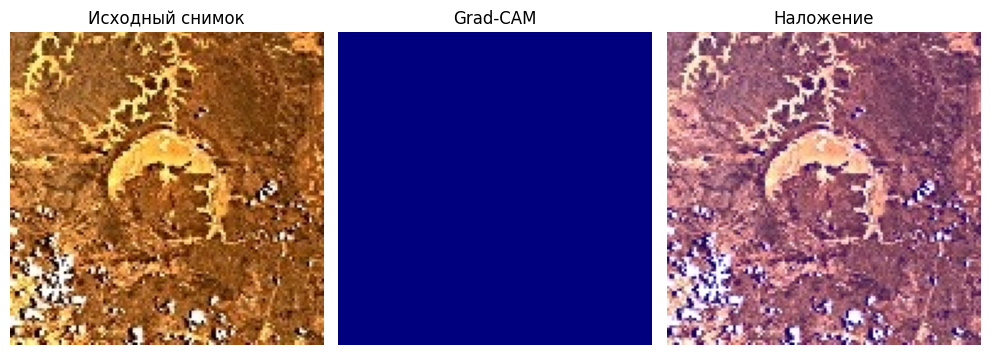

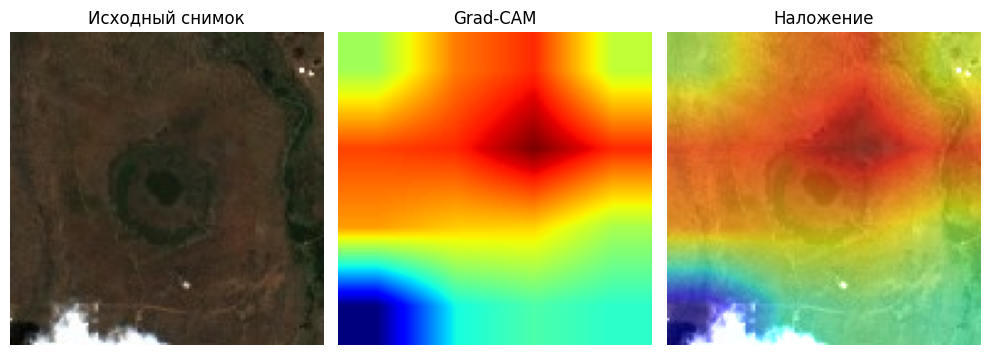

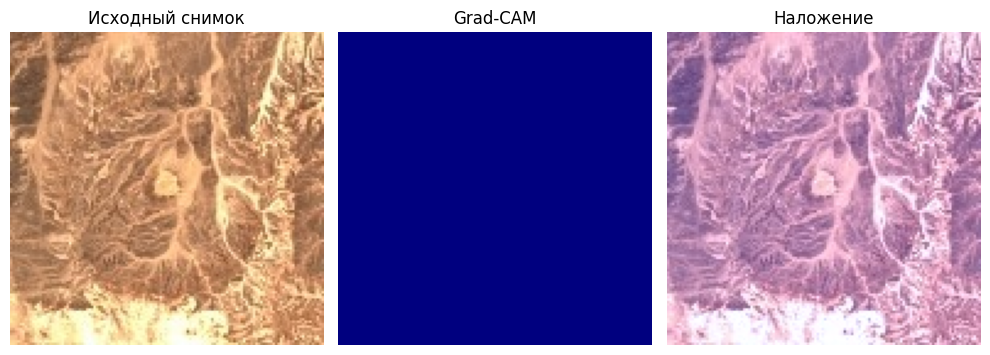

In [114]:
train_structure = random.choice(os.listdir('/content/drive/MyDrive/Dataset/01_Train/ImpactStrctures/'))
val_structure = random.choice(os.listdir('/content/drive/MyDrive/Dataset/02_Val/ImpactStrctures/'))
test_structure = random.choice(os.listdir('/content/drive/MyDrive/Dataset/03_Test/ImpactStrctures/'))

# Вывод класс ImpactStructures
img_path = f'/content/drive/MyDrive/Dataset/01_Train/ImpactStrctures/{train_structure}'
img = tf.keras.utils.load_img(img_path, target_size=(128, 128))
img_array = tf.keras.utils.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) # Создание батча (1, 128, 128, 3)
img_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32)
heatmap = get_gradcam_heatmap(img_tensor, base_model, 'top_conv')
plot_gradcam_comparison(img_path, heatmap)

img_path = f'/content/drive/MyDrive/Dataset/02_Val/ImpactStrctures/{val_structure}'
img = tf.keras.utils.load_img(img_path, target_size=(128, 128))
img_array = tf.keras.utils.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) # Создание батча (1, 128, 128, 3)
img_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32)
heatmap = get_gradcam_heatmap(img_tensor, base_model, 'top_conv')
plot_gradcam_comparison(img_path, heatmap)

img_path = f'/content/drive/MyDrive/Dataset/03_Test/ImpactStrctures/{test_structure}'
img = tf.keras.utils.load_img(img_path, target_size=(128, 128))
img_array = tf.keras.utils.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) # Создание батча (1, 128, 128, 3)
img_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32)
heatmap = get_gradcam_heatmap(img_tensor, base_model, 'top_conv')
plot_gradcam_comparison(img_path, heatmap)

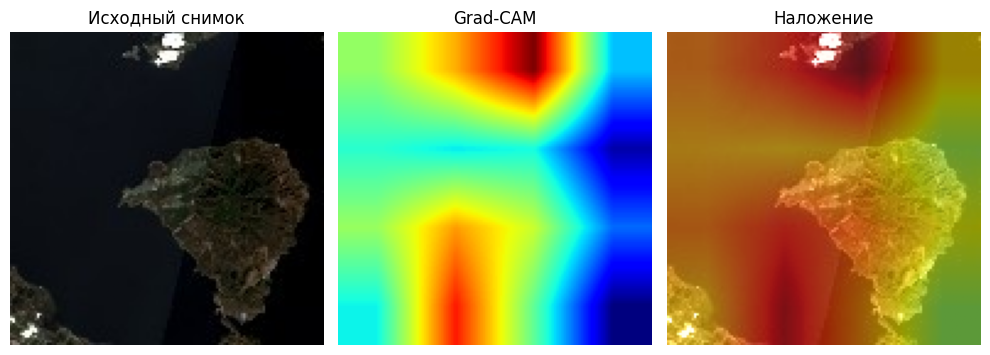

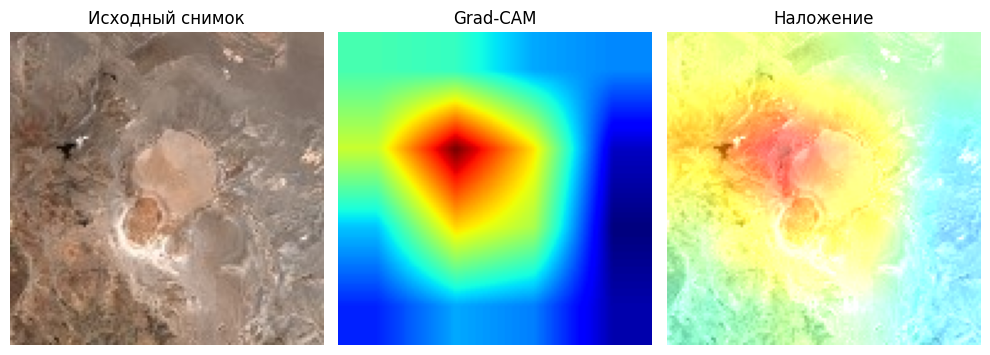

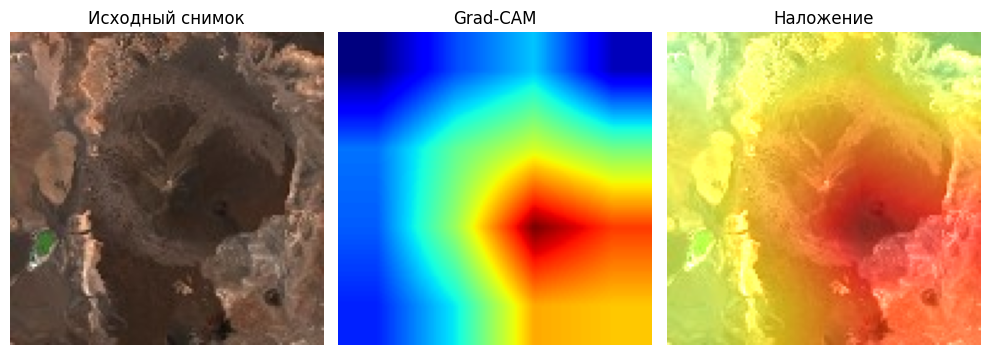

In [113]:
train_structure = random.choice(os.listdir('/content/drive/MyDrive/Dataset/01_Train/VolcanoStructures/'))
val_structure = random.choice(os.listdir('/content/drive/MyDrive/Dataset/02_Val/VolcanoStructures/'))
test_structure = random.choice(os.listdir('/content/drive/MyDrive/Dataset/03_Test/VolcanoStructures/'))

# Вывод класс ImpactStructures
img_path = f'/content/drive/MyDrive/Dataset/01_Train/VolcanoStructures/{train_structure}'
img = tf.keras.utils.load_img(img_path, target_size=(128, 128))
img_array = tf.keras.utils.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) # Создание батча (1, 128, 128, 3)
img_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32)
heatmap = get_gradcam_heatmap(img_tensor, base_model, 'top_conv')
plot_gradcam_comparison(img_path, heatmap)

img_path = f'/content/drive/MyDrive/Dataset/02_Val/VolcanoStructures/{val_structure}'
img = tf.keras.utils.load_img(img_path, target_size=(128, 128))
img_array = tf.keras.utils.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) # Создание батча (1, 128, 128, 3)
img_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32)
heatmap = get_gradcam_heatmap(img_tensor, base_model, 'top_conv')
plot_gradcam_comparison(img_path, heatmap)

img_path = f'/content/drive/MyDrive/Dataset/03_Test/VolcanoStructures/{test_structure}'
img = tf.keras.utils.load_img(img_path, target_size=(128, 128))
img_array = tf.keras.utils.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) # Создание батча (1, 128, 128, 3)
img_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32)
heatmap = get_gradcam_heatmap(img_tensor, base_model, 'top_conv')
plot_gradcam_comparison(img_path, heatmap)

### **Дообучение**

In [109]:
# Дообучение
EfficientNetB0_backbone.trainable = True

for layer in EfficientNetB0_backbone.layers[:-10]:
    layer.trainable = False

base_model.compile(
    optimizer=keras.optimizers.Adam(1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

base_history = base_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    callbacks=[early_stopping],
    verbose=1

)

Epoch 1/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 17s 187ms/step - accuracy: 0.8624 - loss: 0.3576 - val_accuracy: 0.7656 - val_loss: 0.4561
Epoch 2/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - accuracy: 0.8570 - loss: 0.3437 - val_accuracy: 0.7656 - val_loss: 0.4595
Epoch 3/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.8753 - loss: 0.2736 - val_accuracy: 0.7344 - val_loss: 0.4662
Epoch 4/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.8441 - loss: 0.4095 - val_accuracy: 0.7188 - val_loss: 0.4755
Epoch 5/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.8945 - loss: 0.3145 - val_accuracy: 0.7344 - val_loss: 0.4798
Epoch 6/15
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.8963 - loss: 0.2868 - val_accuracy: 0.7500 - val_loss: 0.4873


#### **Оценка качества**

In [54]:
# Метрики на тесте, этап дообучения
metrics = base_model.evaluate(test_ds)
metrics

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.8167 - loss: 0.3642


[0.3495512008666992, 0.8125]

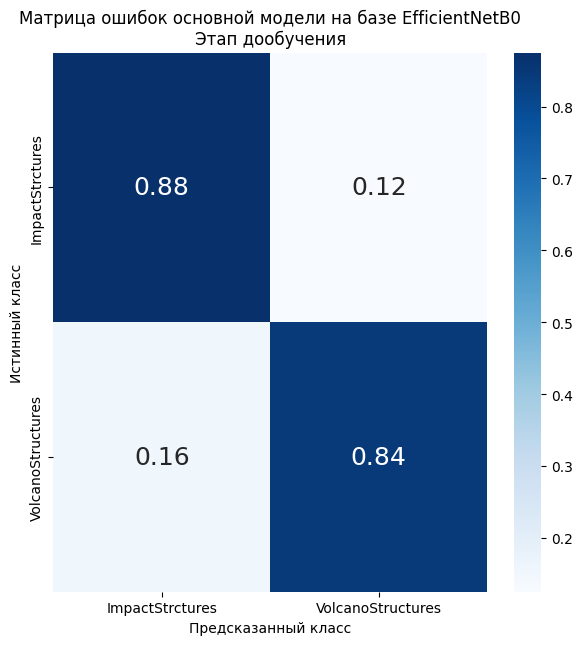

In [55]:
# Оценка качества модели, этап дообучения
y_true_list = []
y_pred_list = []

for images, labels in val_ds:
    preds = base_model.predict(images, verbose=0)

    # Обработка предсказаний
    y_pred_list.extend(np.argmax(preds, axis=1))

    # Обработка меток
    labels_np = labels.numpy()
    if len(labels_np.shape) > 1:
        y_true_list.extend(np.argmax(labels_np, axis=1))
    else:
        y_true_list.extend(labels_np)

# Матрица ошибок, этап дообучения
y_true = np.array(y_true_list)
y_pred = np.array(y_pred_list)

cm = confusion_matrix(y_true, y_pred, normalize='true')

plt.figure(figsize=(7, 7))
sns.heatmap(
    cm,
    annot=True,
    annot_kws={'size': 18},
    fmt='.2f',
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')
plt.title('Матрица ошибок основной модели на базе EfficientNetB0\nЭтап дообучения')
plt.show()

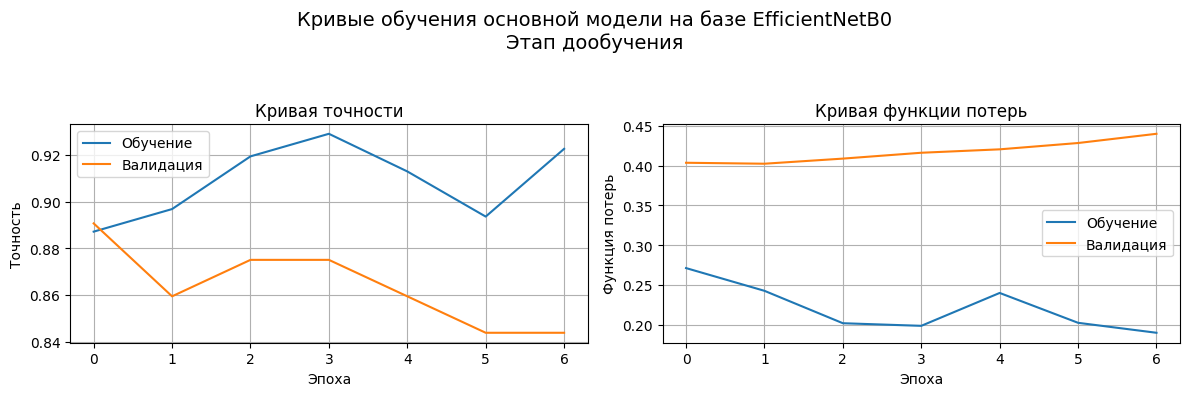

In [56]:
# Функция для визуализации кривых обучения
def plot_training_curves(history):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    axes[0].plot(history.history['accuracy'], label='Обучение')
    axes[0].plot(history.history.get('val_accuracy', []), label='Валидация')
    axes[0].set_title('Кривая точности')
    axes[0].set_xlabel('Эпоха')
    axes[0].set_ylabel('Точность')
    axes[0].legend()
    axes[0].grid(True)

    axes[1].plot(history.history['loss'], label='Обучение')
    axes[1].plot(history.history.get('val_loss', []), label='Валидация')
    axes[1].set_title('Кривая функции потерь')
    axes[1].set_xlabel('Эпоха')
    axes[1].set_ylabel('Функция потерь')
    axes[1].legend()
    axes[1].grid(True)

    fig.suptitle(
        'Кривые обучения основной модели на базе EfficientNetB0\nЭтап дообучения',
        fontsize=14
    )

    plt.tight_layout(rect=[0, 0, 1, 0.93])
    plt.show()


# Визуализация кривых обучения, этап дообучения
plot_training_curves(base_history)

#### **Интерпретация работы**

In [57]:
train_structure = random.choice(os.listdir('/content/drive/MyDrive/Dataset/01_Train/ImpactStrctures/'))
val_structure = random.choice(os.listdir('/content/drive/MyDrive/Dataset/02_Val/ImpactStrctures/'))
test_structure = random.choice(os.listdir('/content/drive/MyDrive/Dataset/03_Test/ImpactStrctures/'))

# Вывод класс ImpactStructures
img_path = f'/content/drive/MyDrive/Dataset/01_Train/ImpactStrctures/{train_structure}'
img = tf.keras.utils.load_img(img_path, target_size=(128, 128))
img_array = tf.keras.utils.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) # Создание батча (1, 128, 128, 3)
img_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32)
heatmap = get_gradcam_heatmap(img_tensor, base_model, 'top_conv')
plot_gradcam_comparison(img_path, heatmap)

img_path = f'/content/drive/MyDrive/Dataset/02_Val/ImpactStrctures/{val_structure}'
img = tf.keras.utils.load_img(img_path, target_size=(128, 128))
img_array = tf.keras.utils.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) # Создание батча (1, 128, 128, 3)
img_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32)
heatmap = get_gradcam_heatmap(img_tensor, base_model, 'top_conv')
plot_gradcam_comparison(img_path, heatmap)

img_path = f'/content/drive/MyDrive/Dataset/03_Test/ImpactStrctures/{test_structure}'
img = tf.keras.utils.load_img(img_path, target_size=(128, 128))
img_array = tf.keras.utils.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) # Создание батча (1, 128, 128, 3)
img_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32)
heatmap = get_gradcam_heatmap(img_tensor, base_model, 'top_conv')
plot_gradcam_comparison(img_path, heatmap)

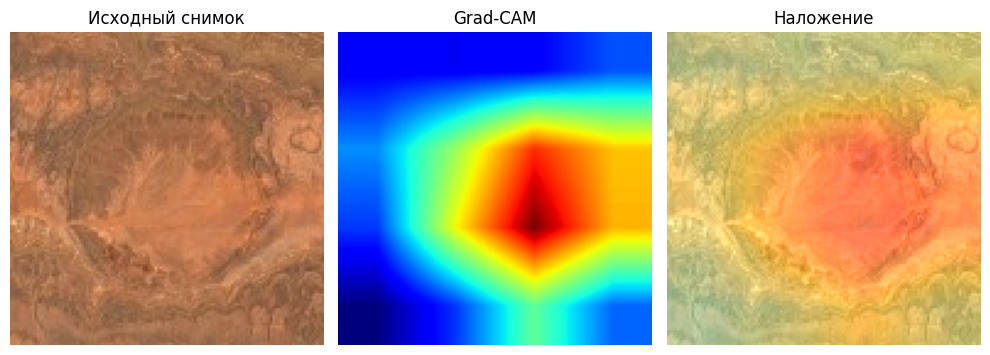

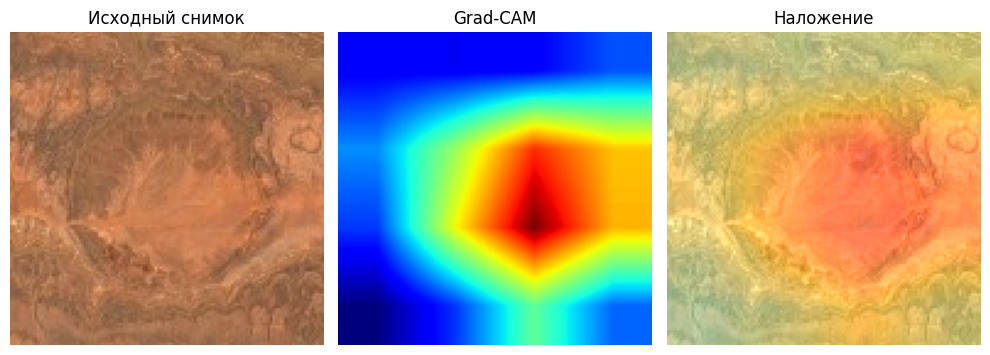

In [98]:
train_structure = random.choice(os.listdir('/content/drive/MyDrive/Dataset/01_Train/VolcanoStructures/'))
val_structure = random.choice(os.listdir('/content/drive/MyDrive/Dataset/02_Val/VolcanoStructures/'))
test_structure = random.choice(os.listdir('/content/drive/MyDrive/Dataset/03_Test/VolcanoStructures/'))

# Вывод класс ImpactStructures
img_path = f'/content/drive/MyDrive/Dataset/01_Train/VolcanoStructures/{train_structure}'
img = tf.keras.utils.load_img(img_path, target_size=(128, 128))
img_array = tf.keras.utils.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) # Создание батча (1, 128, 128, 3)
img_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32)
heatmap = get_gradcam_heatmap(img_tensor, base_model, 'top_conv')
plot_gradcam_comparison(img_path, heatmap)

img_path = f'/content/drive/MyDrive/Dataset/02_Val/VolcanoStructures/{val_structure}'
img = tf.keras.utils.load_img(img_path, target_size=(128, 128))
img_array = tf.keras.utils.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) # Создание батча (1, 128, 128, 3)
img_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32)
heatmap = get_gradcam_heatmap(img_tensor, base_model, 'top_conv')
plot_gradcam_comparison(img_path, heatmap)

img_path = f'/content/drive/MyDrive/Dataset/03_Test/VolcanoStructures/{test_structure}'
img = tf.keras.utils.load_img(img_path, target_size=(128, 128))
img_array = tf.keras.utils.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) # Создание батча (1, 128, 128, 3)
img_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32)
heatmap = get_gradcam_heatmap(img_tensor, base_model, 'top_conv')
plot_gradcam_comparison(img_path, heatmap)

### **Сохранение модели**

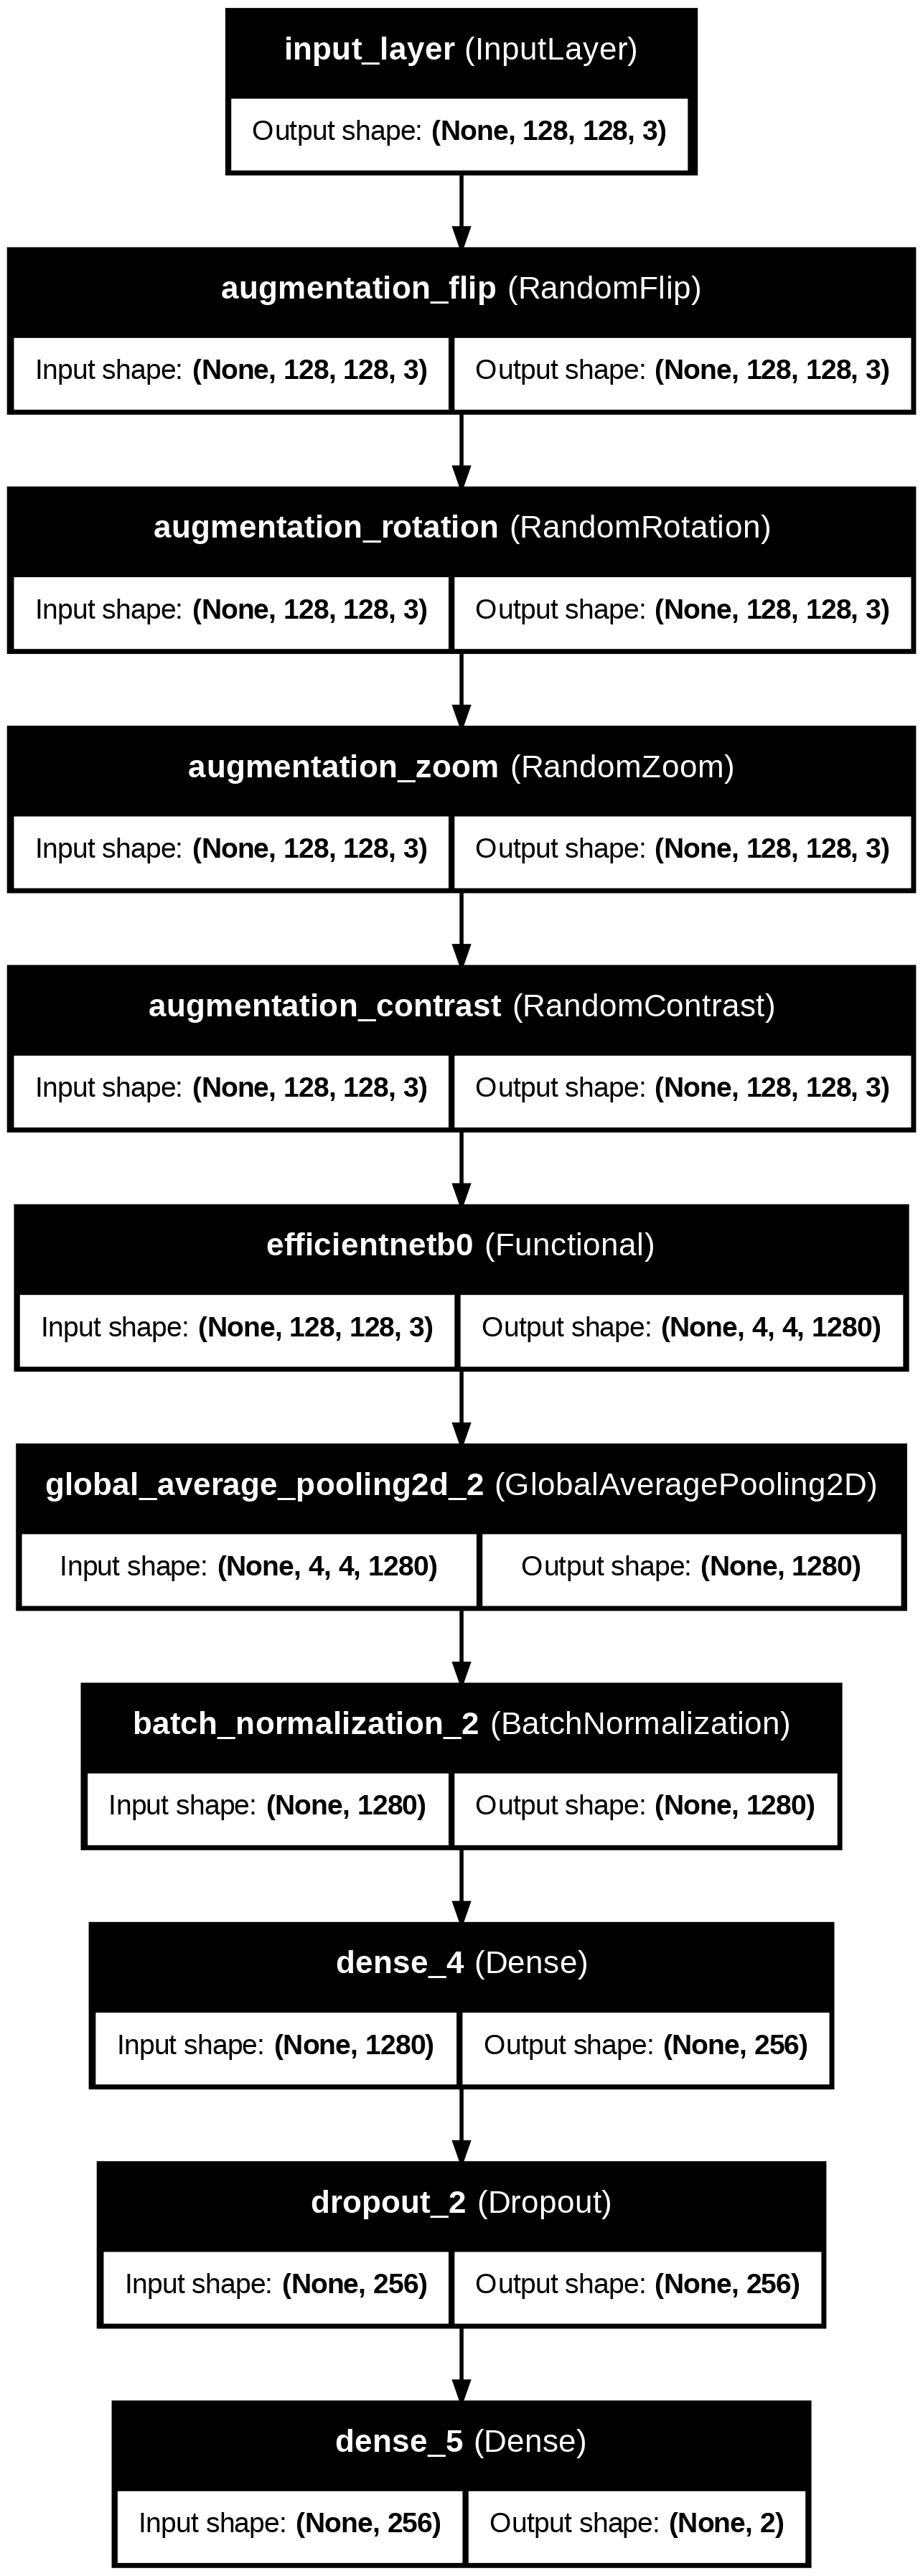

In [117]:
# Сохранение схемы архитектуры модели
plot_model(base_model, to_file='/content/drive/MyDrive/Model/EfficientNetB0_base_model.png', show_shapes=True, show_layer_names=True)

In [118]:
# Сохранение модели
base_model.save('/content/drive/MyDrive/Model/EfficientNetB0_base_model.keras')

# **Модель на основе MobileNetV2 (альтернативная)**

## **Разработка архитектуры**

In [ ]:
# Альтернативная модель
MobileNetV2_backbone = MobileNetV2(
    include_top=False,
    weights='imagenet',
    input_shape=(IMG_SIZE, IMG_SIZE, 3)
)

# Заморозка весов
MobileNetV2_backbone.trainable = False

# Вход
inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3), name='input_layer')

# Аугментация
x = layers.RandomFlip('horizontal', name='augmentation_flip')(inputs)
x = layers.RandomRotation(0.15, name='augmentation_rotation')(x)
x = layers.RandomZoom(0.15, name='augmentation_zoom')(x)
x = layers.RandomContrast(0.2, name='augmentation_contrast')(x)

# Предобработка и базовая модель
x = keras.applications.efficientnet.preprocess_input(x)
x = MobileNetV2_backbone(x)

# Новая голова
x = layers.GlobalAveragePooling2D()(x)
x = layers.BatchNormalization()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.Dropout(0.4)(x)

# Выход
outputs = layers.Dense(NUM_CLASSES, activation='softmax')(x)

# Сборка модели
alt_model = keras.Model(inputs, outputs, name='MobileNetV2_alt_model')

alt_model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

alt_model.summary()

Model: "binary_classification_alt_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ augmentation_flip (RandomFlip)  │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ augmentation_rotation           │ (None, 128, 128, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ augmentation_zoom (RandomZoom)  │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ augmentation_contrast           │ (None, 128, 128, 3)    │             0 │
│ (RandomContrast)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_128            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,591,554 (9.89 MB)

 Trainable params: 331,010 (1.26 MB)

 Non-trainable params: 2,260,544 (8.62 MB)

## **Трансферное обучение**

### **Предобучение**

In [88]:
# Обучение классификатора
alt_history = alt_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    verbose=1
)

NameError: name 'model_v1' is not defined

#### **Оценка качества**

In [89]:
# Метрики на тесте, этап предобучения
metrics = alt_model.evaluate(test_ds)
metrics

NameError: name 'model_v1' is not defined

In [ ]:
# Оценка качества модели, этап предобучения
y_true_list = []
y_pred_list = []

for images, labels in val_ds:
    preds = alt_model.predict(images, verbose=0)

    # Обработка предсказаний
    y_pred_list.extend(np.argmax(preds, axis=1))

    # Обработка меток
    labels_np = labels.numpy()
    if len(labels_np.shape) > 1:
        y_true_list.extend(np.argmax(labels_np, axis=1))
    else:
        y_true_list.extend(labels_np)

# Матрица ошибок, этап предобучения
y_true = np.array(y_true_list)
y_pred = np.array(y_pred_list)

cm = confusion_matrix(y_true, y_pred, normalize='true')

plt.figure(figsize=(7, 7))
sns.heatmap(
    cm,
    annot=True,
    annot_kws={'size': 18},
    fmt='.2f',
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')
plt.title('Матрица ошибок альтернативной модели на базе MobileNetV2\nЭтап предобучения')
plt.show()

In [ ]:
# Функция для визуализации кривых обучения
def plot_training_curves(history):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    axes[0].plot(history.history['accuracy'], label='Обучение')
    axes[0].plot(history.history.get('val_accuracy', []), label='Валидация')
    axes[0].set_title('Кривая точности')
    axes[0].set_xlabel('Эпоха')
    axes[0].set_ylabel('Точность')
    axes[0].legend()
    axes[0].grid(True)

    axes[1].plot(history.history['loss'], label='Обучение')
    axes[1].plot(history.history.get('val_loss', []), label='Валидация')
    axes[1].set_title('Кривая функции потерь')
    axes[1].set_xlabel('Эпоха')
    axes[1].set_ylabel('Функция потерь')
    axes[1].legend()
    axes[1].grid(True)

    fig.suptitle(
        'Кривые обучения альтернативной модели на базе MobileNetV2\nЭтап предобучения',
        fontsize=14
    )

    plt.tight_layout(rect=[0, 0, 1, 0.93])
    plt.show()


# Визуализация кривых обучения, этап предобучения
plot_training_curves(alt_history)

#### **Интерпретация работы модели**

In [ ]:
train_structure = random.choice(os.listdir('/content/drive/MyDrive/Dataset/01_Train/ImpactStrctures/'))
val_structure = random.choice(os.listdir('/content/drive/MyDrive/Dataset/02_Val/ImpactStrctures/'))
test_structure = random.choice(os.listdir('/content/drive/MyDrive/Dataset/03_Test/ImpactStrctures/'))

# Вывод класс ImpactStructures
img_path = f'/content/drive/MyDrive/Dataset/01_Train/ImpactStrctures/{train_structure}'
img = tf.keras.utils.load_img(img_path, target_size=(128, 128))
img_array = tf.keras.utils.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) # Создание батча (1, 128, 128, 3)
img_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32)
heatmap = get_gradcam_heatmap(img_tensor, alt_model, 'top_conv')
plot_gradcam_comparison(img_path, heatmap)

img_path = f'/content/drive/MyDrive/Dataset/02_Val/ImpactStrctures/{val_structure}'
img = tf.keras.utils.load_img(img_path, target_size=(128, 128))
img_array = tf.keras.utils.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) # Создание батча (1, 128, 128, 3)
img_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32)
heatmap = get_gradcam_heatmap(img_tensor, alt_model, 'top_conv')
plot_gradcam_comparison(img_path, heatmap)

img_path = f'/content/drive/MyDrive/Dataset/03_Test/ImpactStrctures/{test_structure}'
img = tf.keras.utils.load_img(img_path, target_size=(128, 128))
img_array = tf.keras.utils.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) # Создание батча (1, 128, 128, 3)
img_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32)
heatmap = get_gradcam_heatmap(img_tensor, alt_model, 'top_conv')
plot_gradcam_comparison(img_path, heatmap)

In [ ]:
train_structure = random.choice(os.listdir('/content/drive/MyDrive/Dataset/01_Train/VolcanoStructures/'))
val_structure = random.choice(os.listdir('/content/drive/MyDrive/Dataset/02_Val/VolcanoStructures/'))
test_structure = random.choice(os.listdir('/content/drive/MyDrive/Dataset/03_Test/VolcanoStructures/'))

# Вывод класс VolcanoStructures
img_path = f'/content/drive/MyDrive/Dataset/01_Train/VolcanoStructures/{train_structure}'
img = tf.keras.utils.load_img(img_path, target_size=(128, 128))
img_array = tf.keras.utils.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) # Создание батча (1, 128, 128, 3)
img_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32)
heatmap = get_gradcam_heatmap(img_tensor, alt_model, 'top_conv')
plot_gradcam_comparison(img_path, heatmap)

img_path = f'/content/drive/MyDrive/Dataset/02_Val/VolcanoStructures/{val_structure}'
img = tf.keras.utils.load_img(img_path, target_size=(128, 128))
img_array = tf.keras.utils.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) # Создание батча (1, 128, 128, 3)
img_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32)
heatmap = get_gradcam_heatmap(img_tensor, alt_model, 'top_conv')
plot_gradcam_comparison(img_path, heatmap)

img_path = f'/content/drive/MyDrive/Dataset/03_Test/VolcanoStructures/{test_structure}'
img = tf.keras.utils.load_img(img_path, target_size=(128, 128))
img_array = tf.keras.utils.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) # Создание батча (1, 128, 128, 3)
img_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32)
heatmap = get_gradcam_heatmap(img_tensor, alt_model, 'top_conv')
plot_gradcam_comparison(img_path, heatmap)

### **Дообучение**

In [ ]:
# Дообучение
MobileNetV2_backbone.trainable = True

for layer in MobileNetV2_backbone.layers[:-10]:
    layer.trainable = False

MobileNetV2_backbone.compile(
    optimizer=keras.optimizers.Adam(1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

alt_history = alt_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[early_stopping],
    verbose=1

)

#### **Оценка качества**

In [120]:
# Метрики на тесте этап дообучения
metrics = alt_model.evaluate(test_ds)
metrics

NameError: name 'alt_model' is not defined

In [ ]:
# Оценка качества модели, этап предобучения
y_true_list = []
y_pred_list = []

for images, labels in val_ds:
    preds = alt_model.predict(images, verbose=0)

    # Обработка предсказаний
    y_pred_list.extend(np.argmax(preds, axis=1))

    # Обработка меток
    labels_np = labels.numpy()
    if len(labels_np.shape) > 1:
        y_true_list.extend(np.argmax(labels_np, axis=1))
    else:
        y_true_list.extend(labels_np)

# Матрица ошибок, этап предобучения
y_true = np.array(y_true_list)
y_pred = np.array(y_pred_list)

cm = confusion_matrix(y_true, y_pred, normalize='true')

plt.figure(figsize=(7, 7))
sns.heatmap(
    cm,
    annot=True,
    annot_kws={'size': 18},
    fmt='.2f',
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')
plt.title('Матрица ошибок альтернативной модели на базе MobileNetV2\nЭтап дообучения')
plt.show()

In [ ]:
# Функция для визуализации кривых обучения
def plot_training_curves(history):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    axes[0].plot(history.history['accuracy'], label='Обучение')
    axes[0].plot(history.history.get('val_accuracy', []), label='Валидация')
    axes[0].set_title('Кривая точности')
    axes[0].set_xlabel('Эпоха')
    axes[0].set_ylabel('Точность')
    axes[0].legend()
    axes[0].grid(True)

    axes[1].plot(history.history['loss'], label='Обучение')
    axes[1].plot(history.history.get('val_loss', []), label='Валидация')
    axes[1].set_title('Кривая функции потерь')
    axes[1].set_xlabel('Эпоха')
    axes[1].set_ylabel('Функция потерь')
    axes[1].legend()
    axes[1].grid(True)

    fig.suptitle(
        'Кривые обучения альтернативной модели на базе MobileNetV2\nЭтап дообучения',
        fontsize=14
    )

    plt.tight_layout(rect=[0, 0, 1, 0.93])
    plt.show()


# Визуализация кривых обучения, этап предобучения
plot_training_curves(alt_history)

#### **Интерпретация работы**

In [ ]:
# def get_gradcam_heatmap(img_tensor, model):
#     # 1. последний conv слой
#     last_conv_layer = None
#     for layer in reversed(model.layers):
#         if len(layer.output.shape) == 4:
#             last_conv_layer = layer
#             break

#     if last_conv_layer is None:
#         raise ValueError('Conv layer not found')

#     # 2. явно берём ПОСЛЕДНИЙ выход (Dense)
#     classifier_output = model.layers[-1].output

#     grad_model = tf.keras.models.Model(
#         inputs=model.input,
#         outputs=[last_conv_layer.output, classifier_output]
#     )

#     with tf.GradientTape() as tape:
#         conv_outputs, predictions = grad_model(img_tensor, training=False)

#         # бинарная классификация
#         loss = predictions[:, 0]

#     grads = tape.gradient(loss, conv_outputs)
#     pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

#     conv_outputs = conv_outputs[0]
#     heatmap = tf.reduce_sum(conv_outputs * pooled_grads, axis=-1)

#     heatmap = tf.maximum(heatmap, 0)
#     heatmap /= tf.reduce_max(heatmap) + 1e-8

#     return heatmap.numpy()

In [120]:
train_structure = random.choice(os.listdir('/content/drive/MyDrive/Dataset/01_Train/ImpactStrctures/'))
val_structure = random.choice(os.listdir('/content/drive/MyDrive/Dataset/02_Val/ImpactStrctures/'))
test_structure = random.choice(os.listdir('/content/drive/MyDrive/Dataset/03_Test/ImpactStrctures/'))

# Вывод класс ImpactStructures
img_path = f'/content/drive/MyDrive/Dataset/01_Train/ImpactStrctures/{train_structure}'
img = tf.keras.utils.load_img(img_path, target_size=(128, 128))
img_array = tf.keras.utils.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) # Создание батча (1, 128, 128, 3)
img_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32)
heatmap = get_gradcam_heatmap(img_tensor, alt_model, 'top_conv')
plot_gradcam_comparison(img_path, heatmap)

img_path = f'/content/drive/MyDrive/Dataset/02_Val/ImpactStrctures/{val_structure}'
img = tf.keras.utils.load_img(img_path, target_size=(128, 128))
img_array = tf.keras.utils.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) # Создание батча (1, 128, 128, 3)
img_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32)
heatmap = get_gradcam_heatmap(img_tensor, alt_model, 'top_conv')
plot_gradcam_comparison(img_path, heatmap)

img_path = f'/content/drive/MyDrive/Dataset/03_Test/ImpactStrctures/{test_structure}'
img = tf.keras.utils.load_img(img_path, target_size=(128, 128))
img_array = tf.keras.utils.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) # Создание батча (1, 128, 128, 3)
img_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32)
heatmap = get_gradcam_heatmap(img_tensor, alt_model, 'top_conv')
plot_gradcam_comparison(img_path, heatmap)

In [120]:
train_structure = random.choice(os.listdir('/content/drive/MyDrive/Dataset/01_Train/VolcanoStructures/'))
val_structure = random.choice(os.listdir('/content/drive/MyDrive/Dataset/02_Val/VolcanoStructures/'))
test_structure = random.choice(os.listdir('/content/drive/MyDrive/Dataset/03_Test/VolcanoStructures/'))

# Вывод класс ImpactStructures
img_path = f'/content/drive/MyDrive/Dataset/01_Train/VolcanoStructures/{train_structure}'
img = tf.keras.utils.load_img(img_path, target_size=(128, 128))
img_array = tf.keras.utils.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) # Создание батча (1, 128, 128, 3)
img_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32)
heatmap = get_gradcam_heatmap(img_tensor, base_model, 'top_conv')
plot_gradcam_comparison(img_path, heatmap)

img_path = f'/content/drive/MyDrive/Dataset/02_Val/VolcanoStructures/{val_structure}'
img = tf.keras.utils.load_img(img_path, target_size=(128, 128))
img_array = tf.keras.utils.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) # Создание батча (1, 128, 128, 3)
img_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32)
heatmap = get_gradcam_heatmap(img_tensor, base_model, 'top_conv')
plot_gradcam_comparison(img_path, heatmap)

img_path = f'/content/drive/MyDrive/Dataset/03_Test/VolcanoStructures/{test_structure}'
img = tf.keras.utils.load_img(img_path, target_size=(128, 128))
img_array = tf.keras.utils.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) # Создание батча (1, 128, 128, 3)
img_tensor = tf.convert_to_tensor(img_array, dtype=tf.float32)
heatmap = get_gradcam_heatmap(img_tensor, base_model, 'top_conv')
plot_gradcam_comparison(img_path, heatmap)

## **Сохранение модели**

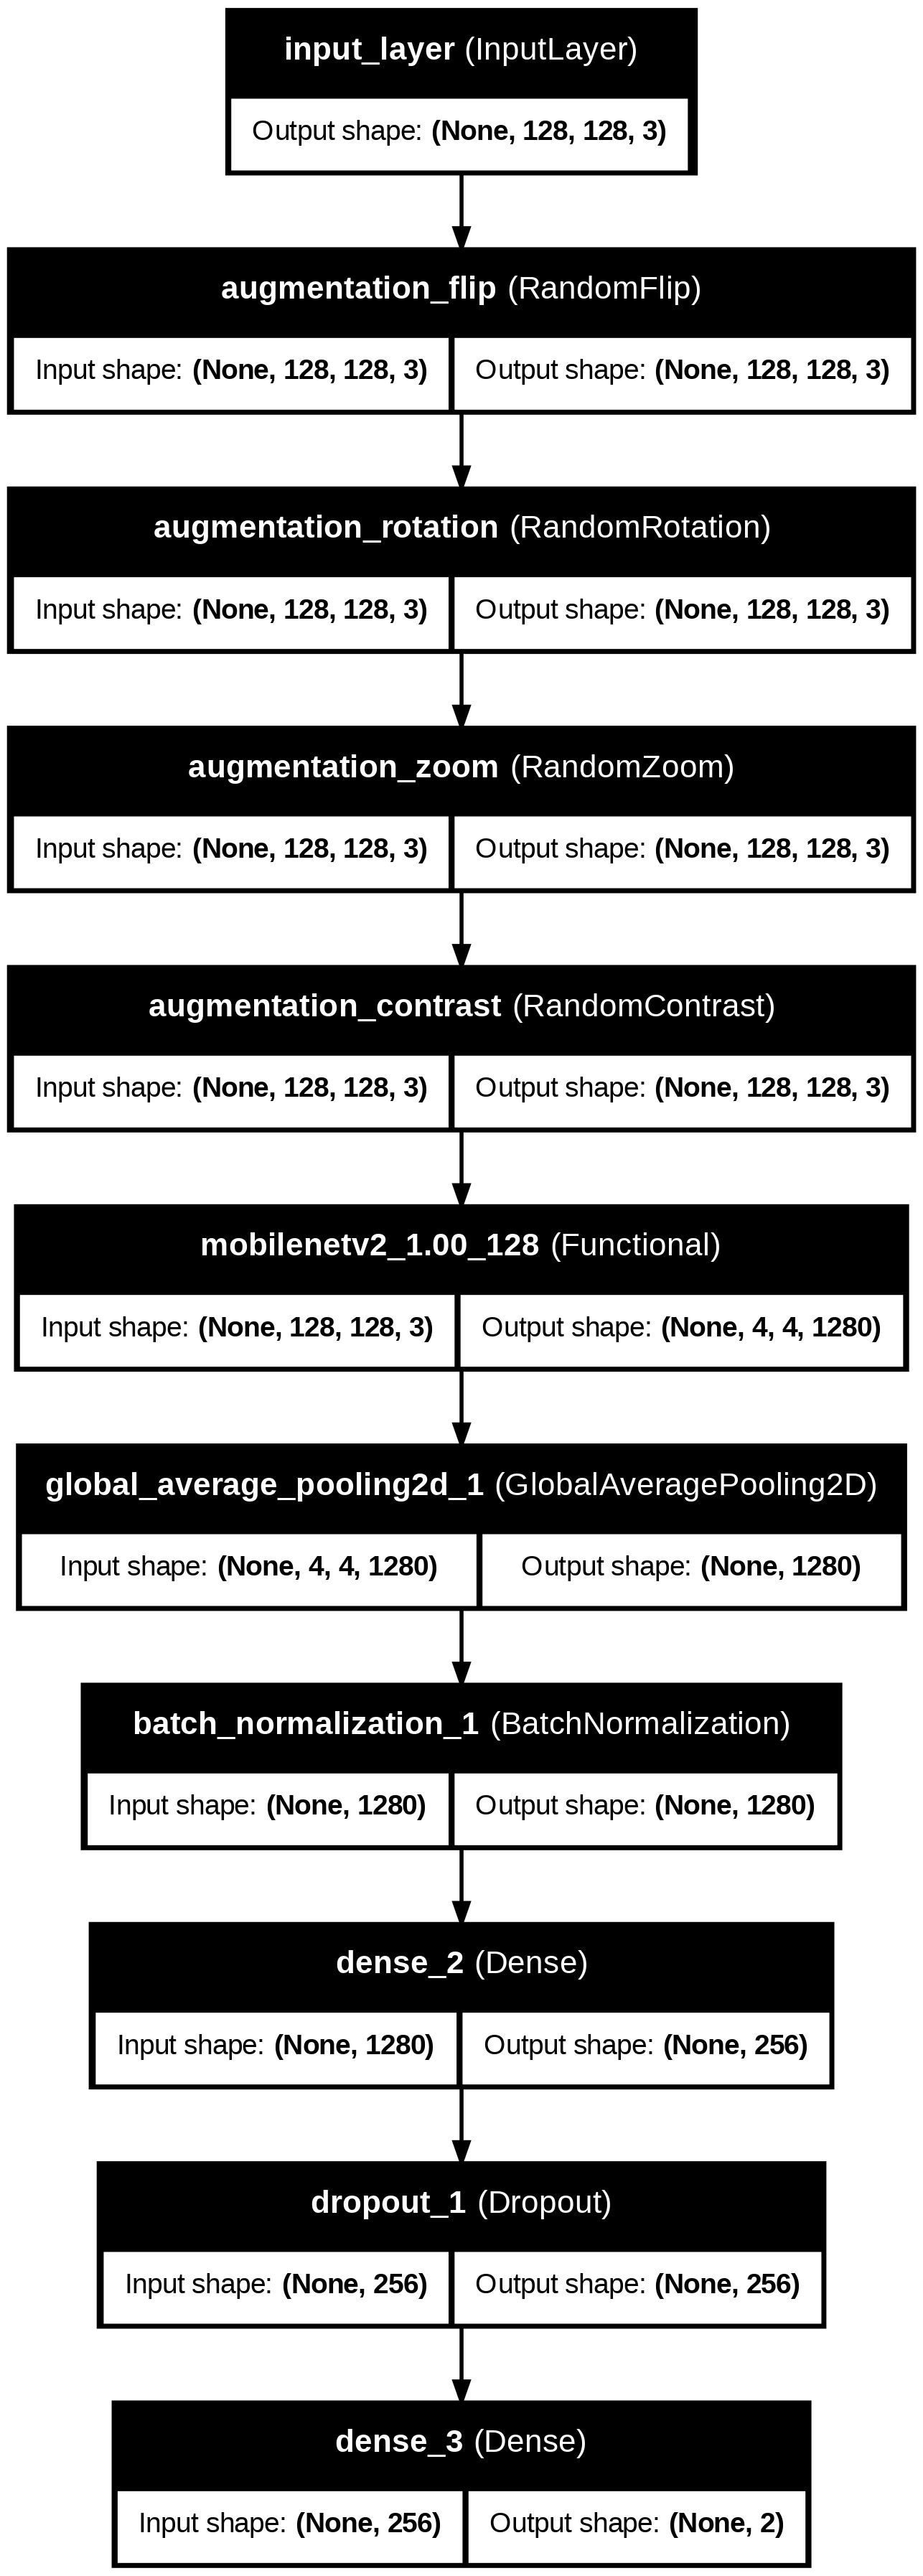

In [ ]:
# Сохранение схемы архитектуры модели
plot_model(alt_model, to_file='/content/drive/MyDrive/Model/MobileNetV2_alt_model.png', show_shapes=True, show_layer_names=True)

In [ ]:
# Сохранение модели
alt_model.save('/content/drive/MyDrive/Model/MobileNetV2_alt_model.keras')